In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [13]:
# Load the dataset
file_path = 'cleaned_electricity_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

                            CONS_NO  FLAG  2014/1/1  2014/1/10  2014/1/11  \
0  0387DD8A07E07FDA6271170F86AD9151     1       0.0       0.00       0.00   
1  01D6177B5D4FFE0CABA9EF17DAFC2B84     1       0.0       0.00       0.00   
2  4B75AC4F2D8434CFF62DB64D0BB43103     1       0.0       0.00       0.00   
3  B32AC8CC6D5D805AC053557AB05F5343     1       0.0       0.00       0.00   
4  EDFC78B07BA2908B3395C4EB2304665E     1       2.9       3.42       3.81   

   2014/1/12  2014/1/13  2014/1/14  2014/1/15  2014/1/16  ...  2016/9/29  \
0       0.00       0.00       0.00       0.00       0.00  ...       9.96   
1       0.00       0.00       0.00       0.00       0.00  ...       0.00   
2       0.00       0.00       0.00       0.00       0.00  ...       0.00   
3       0.00       0.00       0.00       0.00       0.00  ...       9.99   
4       4.58       3.56       4.25       3.86       3.53  ...      10.37   

   2016/9/3  2016/9/30  2016/9/4  2016/9/5  2016/9/6  2016/9/7  2016/9/8  \
0   

In [14]:
# Separate features and labels
X = df.iloc[:, 2:-1]  # all columns except the 'FLAG' and 'CONSUMER_ID'
y = df['FLAG']        # the anomaly flag column


In [15]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data to match LSTM expected input shape (samples, time steps, features)
time_steps = 30  # Define a time window of 30 days for prediction
X_sequences = []

for i in range(time_steps, X_scaled.shape[0]):
    X_sequences.append(X_scaled[i - time_steps:i, :])

X_sequences = np.array(X_sequences)
y_sequences = y[time_steps:].values


In [16]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_sequences.shape[1], X_sequences.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_sequences, y_sequences, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 6.6928 - val_loss: 0.0448
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.3213 - val_loss: 0.0919
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3113 - val_loss: 0.1577
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2209 - val_loss: 0.2496
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1730 - val_loss: 0.2605
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1409 - val_loss: 0.2031
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1064 - val_loss: 0.1328
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0753 - val_loss: 0.0830
Epoch 9/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0510 - val_loss: 0.0560
Epoch 10/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0468 - val_loss: 0.0747


In [20]:
# Extract features by getting the output of the last Dense layer
feature_extractor = Sequential(model.layers[:-1])  # Removing the output layer to get intermediate features
X_features = model.predict(X_sequences)

# Print a sample of the extracted features
print("Extracted Features Shape:", X_features.shape)
print("Extracted Features (first 5 samples):")
print(X_features[:5])


229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Extracted Features Shape: (7322, 1)
Extracted Features (first 5 samples):
[[0.95609033]
 [0.9547905 ]
 [0.9442924 ]
 [0.94936883]
 [0.9546002 ]]


In [23]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# model: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred = rf_model.predict(X_test)


In [24]:
print("\nConfusion Matrix (RandomForest):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (RandomForest):")
print(classification_report(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix (RandomForest):
[[699  49]
 [ 58 659]]

Classification Report (RandomForest):
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       748
           1       0.93      0.92      0.92       717

    accuracy                           0.93      1465
   macro avg       0.93      0.93      0.93      1465
weighted avg       0.93      0.93      0.93      1465


Accuracy: 0.926962457337884


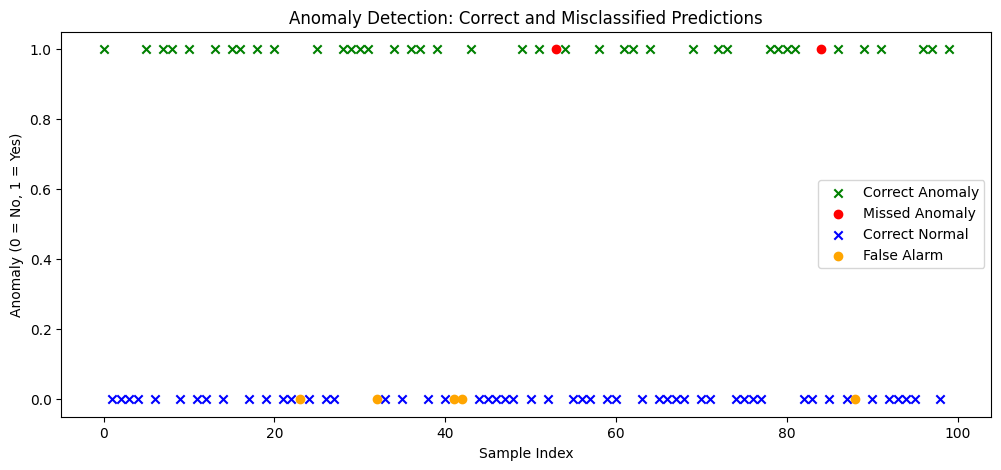

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Selecting a subset of predictions and actual labels for simplicity
subset_size = 100
y_test_subset = y_test[:subset_size]
y_pred_subset = y_pred[:subset_size]


correct_anomalies = np.where((y_test_subset == 1) & (y_pred_subset == 1))[0]  # True Positives
missed_anomalies = np.where((y_test_subset == 1) & (y_pred_subset == 0))[0]   # False Negatives
correct_normals = np.where((y_test_subset == 0) & (y_pred_subset == 0))[0]     # True Negatives
false_alarms = np.where((y_test_subset == 0) & (y_pred_subset == 1))[0]        # False Positives


plt.figure(figsize=(12, 5))
plt.scatter(correct_anomalies, y_test_subset[correct_anomalies], color='green', label='Correct Anomaly', marker='x')
plt.scatter(missed_anomalies, y_test_subset[missed_anomalies], color='red', label='Missed Anomaly', marker='o')
plt.scatter(correct_normals, y_test_subset[correct_normals], color='blue', label='Correct Normal', marker='x')
plt.scatter(false_alarms, y_test_subset[false_alarms], color='orange', label='False Alarm', marker='o')


plt.xlabel('Sample Index')
plt.ylabel('Anomaly (0 = No, 1 = Yes)')
plt.title('Anomaly Detection: Correct and Misclassified Predictions')
plt.legend()
plt.show()
